In [1]:
import aplpy
import healpy as hp
import numpy as np
import astropy.io.fits as fits
import pandas as pd
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt

def fits_display(image_file, units = 'Intensity (MJy/sr)'):
    
 
    # Create a new figure
    fig = aplpy.FITSFigure(image_file)

    #Show the colorscale
    fig.show_colorscale()

    #Make ticks white
    fig.ticks.set_color('white')

    # Make labels smaller
    fig.tick_labels.set_font(size=15)
    
    # Round out those tick labels:
    fig.tick_labels.set_xformat('ddd.dd')
    fig.tick_labels.set_yformat('ddd.dd')
    
    # Overlay a grid
    fig.add_grid()
    fig.grid.set_alpha(0.5)
    
    # Add a colorbar
    fig.add_colorbar()
    fig.colorbar.set_axis_label_text(units)
    
    return fig


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# Get the Planck COMMANDER-AME spdust template spectrum
  * Calculate a correction factor as a function of peak frequency
  * Calculate each pixel's integrated AME intensity
  * See how the integrated intensity compares to IR

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


Text(0,0.5,u'Normalized Density')

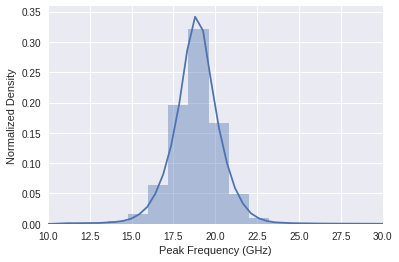

In [2]:
ame_freq_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_FREQ_MEAN.fits')
nuhist = sb.distplot(ame_freq_allsky[ame_freq_allsky!=hp.UNSEEN],
            rug=False )

nuhist.set_xlim(10,30)
nuhist.set_xlabel("Peak Frequency (GHz)")
nuhist.set_ylabel("Normalized Density")

In [3]:
ame_hdu = fits.open('../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits.gz')
ame_hdu.info()
spdust_temp = pd.DataFrame(ame_hdu[3].data)
spdust_temp.head()
ame_hdu[3].header['BITPIX']

Filename: ../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       5   ()      
  1  COMP-MAP-AME1    1 BinTableHDU     75   786432R x 6C   [E, E, E, E, E, E]   
  2  COMP-MAP-AME2    1 BinTableHDU     64   786432R x 3C   [E, E, E]   
  3  SPINNING-DUST-TEMP    1 BinTableHDU     62   1000R x 2C   [D, D]   


8

<bound method AxesSubplot.set_xticks of <matplotlib.axes._subplots.AxesSubplot object at 0x2b9d2509fb90>>

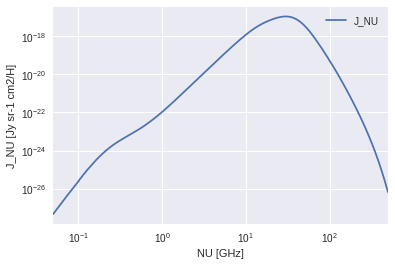

In [4]:
p = spdust_temp.plot(x='NU', 
                     y='J_NU')
p.set_xlabel("{} [{}]".format(ame_hdu[3].header['TTYPE1'],ame_hdu[3].header['TUNIT1']))
p.set_ylabel("{} [{}]".format(ame_hdu[3].header['TTYPE2'],ame_hdu[3].header['TUNIT2']))
p.set_xscale('log')
p.set_yscale('log')
p.set_xticks




# Reproduce Figure 4 (Spinning dust)
from Planck Collaboration: Diffuse component separation: Foreground maps

Brightness temperature for spinning dust emission at a given frequency is defined as follows (see. Table 4, PC2015X): 

$s_{sd} = A_{sd} * (\frac{\nu_0}{\nu})^2$

Keeping in mind that $f_{sd}$ is not an analytical function. It's a table of $J(\\nu)$ values copied from Haimoud+ (2011), and has environmental physics and grain assumptions already baked-in. The COMMANDER modeling, like the WMAP modeling before it, doesn't parametrize these assumptions- they just morph the function by applying a frequency shift factor. Although the spinning dust model `spdust` takes gas density, temperature, grain dipole moment, geometry, and axes of rotation as parameters, the COMMANDER fitting simplifies the problem to 2 parameters: effective peak frequency (after the shift from the 30 GHz peak, found in the assumed template) and a brightness temperature at an arbitrary "reference frequency."$

This approach however resulted in dust-correlated residuals. They compoensate by adding a second spatially constant spdust component. Their fits converged on 33.5 GHz for the peak of this component. 

We would like to note here that this results in one spdust component with a peak within the Planck-WMAP convered frequemcy ramge, and another (the spatially varying frequency component)that is typically below the shortest WMAP band. Thus the issue must be revisited when new low-frequency data becomes available. We consider this AME frequency map to be sufficient for the moment, but as the PC themselves warn in the COMMANDER paper, we have to be extrememly cautious in the physical interpretation of comparisons with this map.

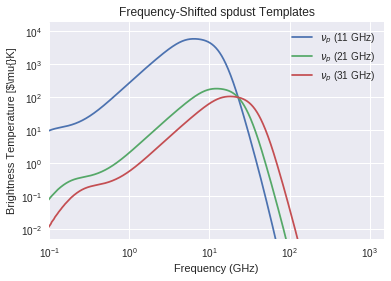

In [5]:


ame_hdu = fits.open('../Data/raw/COM_CompMap_AME-commander_0256_R2.00.fits.gz')
spdust_temp = pd.DataFrame(ame_hdu[3].data)

def getShiftedFsd( 
          f_sd,         # spdust template spectrum
          A_sd = 100.0, # brightness temp in uK
          nu_p  = 20.0, # desired peak temperature
          nu_0  = 22.8, # freq. at which COMMANDER map temp was quoted
          nu_p0 = 30.0  # peak freq. of the original spdust template
        ):
    
    nu_trans_fact = (nu_0/f_sd.NU)**2
    
    temp_trans_fact = (np.interp((f_sd.NU*nu_p0)/nu_p,f_sd.NU, f_sd.J_NU ) / \
                  np.interp((nu_0*nu_p0)/nu_p,f_sd.NU, f_sd.J_NU ))
    
    f_sd_shifted = A_sd * nu_trans_fact * temp_trans_fact
    
    
    return f_sd_shifted



spdust_temp["$\\nu_p$ (11 GHz)"] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 11.0)

spdust_temp['$\\nu_{p}$ (21 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 21.0)

spdust_temp['$\\nu_{p}$ (31 GHz)'] = getShiftedFsd(
                        f_sd = spdust_temp.copy(),
                        nu_p = 31.0)

#spdust_temp['$\\nu_{p}$ (30 GHz)'] = getShiftedFsd(
#                        f_sd = spdust_temp.copy(),
#                        nu_p = 30.0)

plt.figure()
p = spdust_temp.drop(['J_NU'], axis=1).plot(x='NU')

#p.set_xlabel("{} [{}]".format(ame_hdu[3].header['TTYPE1'],ame_hdu[3].header['TUNIT1']))
p.set_ylabel("Brightness Temperature [$\mu{}K]")
p.set_xlabel("Frequency (GHz)")
p.set_xscale('log')
p.set_yscale('log')
p.set_ylim((5e-3,2e4))
p.set_xlim((1e-1,1.5e3))
plt.title("Frequency-Shifted spdust Templates")
plt.savefig("../Plots/AME_commander_freqshift_templ.pdf")
plt.show()

# Numerically itnegrate the shifted  curves to get numerical intensity

A detail not fully addressed in other works, Hensley+ (2016), PC.., is that the COMMANDER map is given in brightness temperature at a reference frequency. This is useful for quickly assesing the relative contribution of intensity in Planck, WMAP bands at 22.8GHZ and 41GHZ Hensley+ (2016). It is a bit less physically intuitive however, when attempting to interpret the AME itself. Hensley+ (2016) calculated the brightness temperature for each component, at a common 30 GHz reference frequency, allowing the total brightness of AME (combinging spatially fixed and varying components) to be evaluated. We consider this to be a good approximation, but would also like to take it a step further. The available commander parameters allow us to obtain a somewhat more robust metric of AME, by integrating the fitted spinning dust functions, and combing the two components. This would be a quantity more analagous to the radiance of thermal dust. 

In [6]:
spdust_temp.head()

,NU,J_NU,$\nu_p$ (11 GHz),$\nu_{p}$ (21 GHz),$\nu_{p}$ (31 GHz)
0,0.050231,4.609770e-28,2.294688,0.007111,0.001136
1,0.050696,4.865184e-28,2.405315,0.007358,0.001115
2,0.051165,5.134620e-28,2.472371,0.007613,0.001095
3,0.051638,5.418841e-28,2.537264,0.007876,0.001075
4,0.052116,5.718646e-28,2.603476,0.008148,0.001081


### Actual integration:
We'll use trapazoidal numerical integration, enabled by the `numpy.trapz` function.


In [7]:
spdust_int_21 = np.trapz(y = abs(np.log(spdust_temp['$\\nu_{p}$ (21 GHz)'])),
                         x = np.log(spdust_temp['NU']), 
                         axis=0)
print spdust_int_21
print (np.log(spdust_temp['$\\nu_{p}$ (21 GHz)'].max()+abs(np.log(spdust_temp['$\\nu_{p}$ (21 GHz)'].min()))) * np.log(500))

45.0941952506
33.1333751783


In [8]:
def getIntegral(nu_peak, t_peak, f_sd, fix=False):
    
    if fix==True:
        nu_ref = 41.0
    else: 
        nu_ref = 28.5
    
    f_sd_shifted = getShiftedFsd( 
          f_sd, 
          A_sd = t_peak, # uK
          nu_p  = nu_peak, # GHz
          nu_0  = nu_ref, # From PR2 AME map
          nu_p0 = 30.0 # From spdust templ.
        )
    
    integral = np.trapz(y = f_sd_shifted,
                        x = f_sd.NU, 
                         axis=0)
    return integral

print getIntegral(29, 10000, spdust_temp)

377523.709646


In [9]:
LOri_ame1_freq = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_freq.fits')
LOri_ame1_I    = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits')
LOri_ame2_I    = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME2_I_256.fits')
nu_fix = 33.5
nu_fix_ref = 41.0
LOri_ame1_rad  = np.array([getIntegral(LOri_ame1_freq.flatten()[i], LOri_ame1_I.flatten()[i], spdust_temp) for i in range(0,2500)])
LOri_ame2_rad  = np.array([getIntegral(nu_fix, LOri_ame1_I.flatten()[i], spdust_temp, fix=True) for i in range(0,2500)])



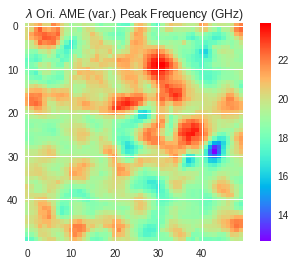

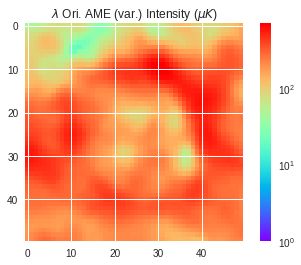

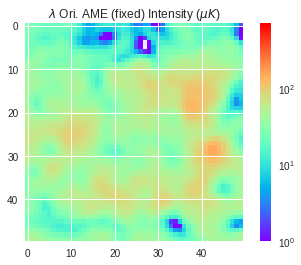

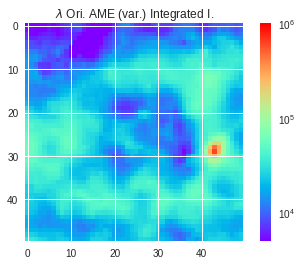

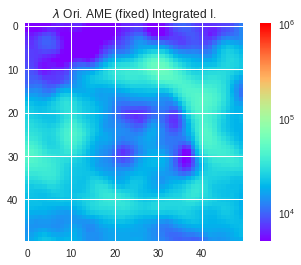

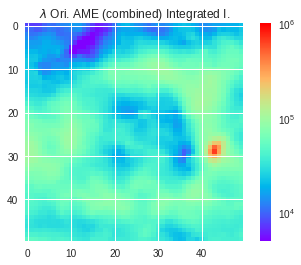

In [10]:
cmap = "rainbow"
from matplotlib.colors import LogNorm

norm = LogNorm()
plt.imshow(LOri_ame1_freq, cmap=cmap)
plt.title("$\lambda$ Ori. AME (var.) Peak Frequency (GHz)")
plt.colorbar()
plt.savefig("../Plots/LOri/AME1_freq.pdf")
plt.show()

plt.imshow(LOri_ame1_I, cmap=cmap, vmin = 1, vmax=700, norm=norm)
plt.title("$\lambda$ Ori. AME (var.) Intensity ($\mu{}K$)")
plt.colorbar()
plt.savefig("../Plots/LOri/AME1_temp.pdf")
plt.show()

plt.imshow(LOri_ame2_I, cmap=cmap,  vmin = 1, vmax=700, norm=norm)
plt.title("$\lambda$ Ori. AME (fixed) Intensity ($\mu{}K$)")
plt.colorbar()
plt.savefig("../Plots/LOri/AME2_temp.pdf")
plt.show()

plt.imshow(LOri_ame1_rad.reshape(50,50), cmap=cmap,  vmin = 5e3, vmax=1e6, norm=norm)
plt.title("$\lambda$ Ori. AME (var.) Integrated I.")
plt.colorbar()
plt.savefig("../Plots/LOri/AME1_rad.pdf")
plt.show()

plt.imshow(LOri_ame2_rad.reshape(50,50), cmap=cmap,  vmin = 5e3, vmax=1e6, norm=norm)
plt.title("$\lambda$ Ori. AME (fixed) Integrated I.")
plt.colorbar()
plt.savefig("../Plots/LOri/AME2_rad.pdf")
plt.show()

ame_combined_rad = (LOri_ame2_rad+LOri_ame1_rad).reshape(50,50)

plt.imshow(ame_combined_rad, cmap=cmap,  vmin = 5e3, vmax=1e6, norm=norm)
plt.title("$\lambda$ Ori. AME (combined) Integrated I.")
plt.colorbar()
plt.savefig("../Plots/LOri/AMEcombined_rad.pdf")
plt.show()

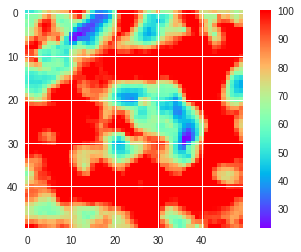

In [11]:
PR2_Idust = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_PR2_Idust.fits').flatten()

ame_combined_dust_rad_ratio = ame_combined_rad / PR2_Idust.reshape((50,50))

plt.imshow(
    ame_combined_dust_rad_ratio, 
    cmap=cmap,
    vmax=100)

plt.colorbar()
plt.show()
#plt.hist(ame_combined_dust_rad_ratio, xrange=(50,200))
#plt.show()

In [12]:
lori_df = pd.DataFrame()
lori_df_mask = pd.DataFrame()
lori_df['A9']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_9_256.fits').flatten()
lori_df['D12']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_12_256.fits').flatten()
lori_df['I12']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_12_256.fits').flatten()
lori_df['A18'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_18_256.fits').flatten()
lori_df['D25']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_25_256.fits').flatten()
lori_df['I25']  = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_iras_25_256.fits').flatten()
lori_df['D60'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_dirbe_60_256.fits').flatten()
lori_df['A65'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_65_256.fits').flatten()
lori_df['A90'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_90_256.fits').flatten()
lori_df['A140'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_140_256.fits').flatten()
lori_df['A160'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_akari_160_256.fits').flatten()
lori_df['P857'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_857_256.fits').flatten()
lori_df['P545'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_planck_545_256.fits').flatten()
lori_df['AME'] = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits').flatten()
lori_df_mask['mask'] = fits.getdata('/work1/users/aaronb/Codebrary/Python/Projects/DIRBE_IRAS_Check/data/LOri_256_mask.fits').flatten()


lori_df_mask['mask'][lori_df['D12']>=1.3] = np.nan

for i in range(0, len(lori_df_mask['mask']) ):
    
    if np.isnan(lori_df_mask['mask'].iloc[i]):
    
        #print 'NaNpix at {}'.format(i)
        lori_df.iloc[i] = np.nan
        

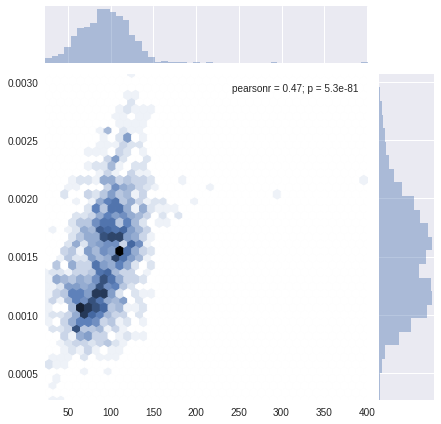

In [13]:
sb.jointplot(ame_combined_dust_rad_ratio.flatten(), lori_df.A9.values.flatten()/PR2_Idust , kind= "hex")

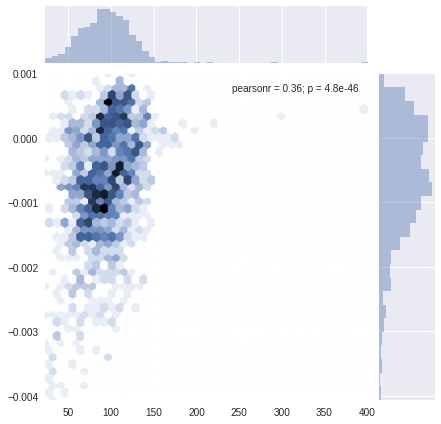

In [24]:
sb.jointplot(ame_combined_dust_rad_ratio.flatten(), lori_df.A18.values.flatten()/PR2_Idust , kind= "hex")

In [16]:
ame1_I = fits.getdata('/work1/users/aaronb/Codebrary/latex/CosmicDust/Data/LOri_AME1_I_256.fits').flatten()

In [17]:
ame_rad_ratio = ame1_I / PR2_Idust
ame_rad_diff = ame1_I - PR2_Idust

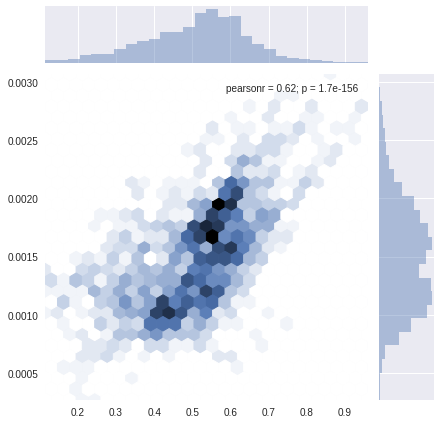

In [18]:
sb.jointplot(ame_rad_ratio.flatten(), lori_df.A9.values.flatten()/PR2_Idust , kind= "hex")

In [19]:
# Make frequency corrected all-sky maps

In [22]:
ame1_freq_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_FREQ_MEAN.fits', nest=True)
ame1_temp_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_I_MEAN.fits', nest=True)
ame2_temp_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_fix_I_MEAN.fits', nest=True)

nu_fix = 33.5

ame1_rad_allsky  = np.array(
    [
        getIntegral(
            ame1_freq_allsky[i], 
            ame1_temp_allsky[i], 
            spdust_temp, 
            fix=True) for i in range(0,hp.nside2npix(256))
    ]
)

print "AME1 finished"

ame2_rad_allsky  = np.array(
    [
        getIntegral(
            nu_fix, 
            ame2_temp_allsky[i], 
            spdust_temp, 
            fix=True) for i in range(0,hp.nside2npix(256))
    ]
)





NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Ordering converted to NEST
AME1 finished


In [23]:
hp.write_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_INT_I.fits', 
             ame1_rad_allsky,
             nest=True,
            coord='G',
            overwrite=True)

hp.write_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_fix_INT_I.fits', 
             ame2_rad_allsky,
             nest=True,
            coord='G',
            overwrite=True)

In [ ]:
#fix_INT_I =

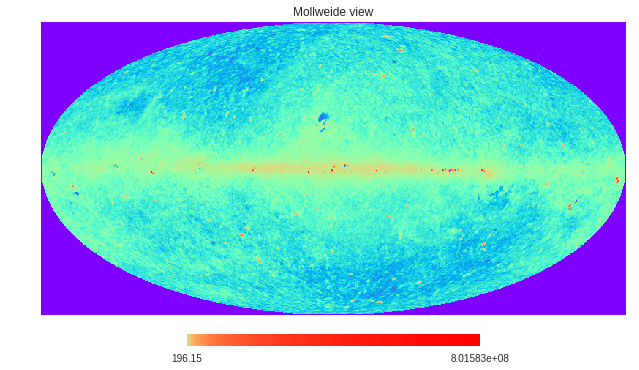

In [38]:
hp.mollview(ame1_rad_allsky, norm='log',cmap="rainbow", nest=True)

In [ ]:
hp.mollview(ame1_freq_allsky, 
            norm='log',
            cmap="rainbow", 
            nest=True)

In [ ]:
sb.distplot(ame1_rad_allsky)
sb.distplot(ame1_freq_allsky)


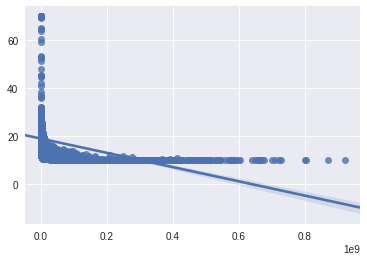

In [39]:
sb.regplot(ame1_rad_allsky, ame1_freq_allsky )

In [ ]:
sb.jointplot(ame1_rad_allsky, ame1_freq_allsky, kind = "hex" )

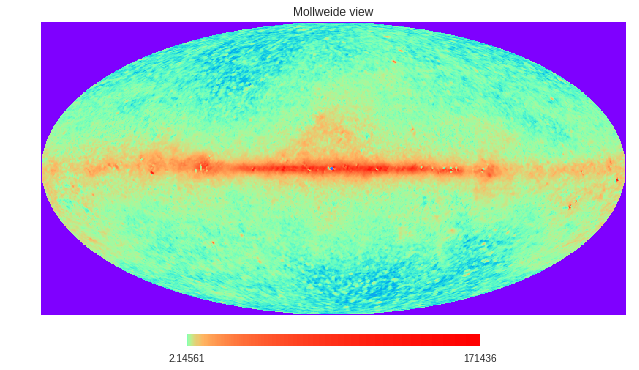

In [37]:
hp.mollview(ame2_rad_allsky, norm='log',cmap="rainbow", nest=True)

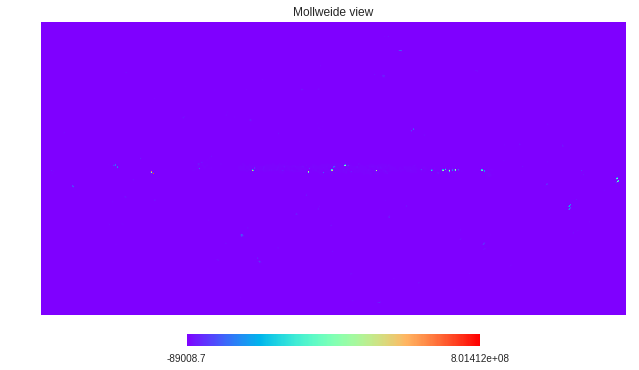

In [36]:
hp.mollview(ame1_rad_allsky-ame2_rad_allsky, norm='symlog', nest=True, cmap="rainbow")

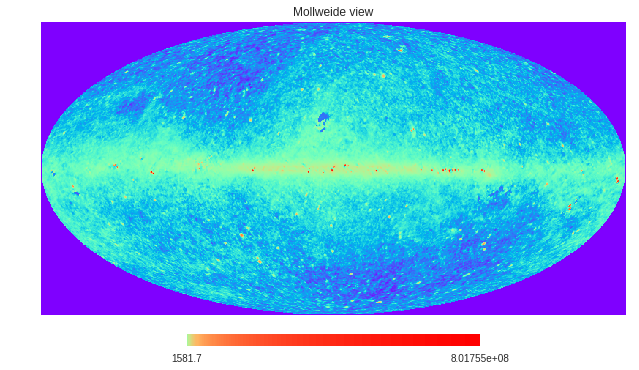

In [33]:
hp.mollview(ame1_rad_allsky+ame2_rad_allsky, norm='log', nest=True, cmap="rainbow")